In [1]:
import numpy as np
from tensorly import kruskal_to_tensor, kron
from tensorly.tenalg import khatri_rao
from sporco.linalg import fftconv, fftn, ifftn
from sporco.metric import snr
from scipy import linalg
from scipy.sparse import csr_matrix, hstack, kron, identity, diags
from scipy.sparse.linalg import eigsh
import time

from TC_FISTA import *

import matplotlib.pyplot as plt

Using numpy backend.


In [2]:
# SIZE of the input signal Y
N1 = 50
N2 = 50
N3 = 50
N = np.prod((N1, N2, N3))

R = 2
W1 = 5
W2 = 5
W3 = 5
K = 3

In [3]:
# Generate signal Y
np.random.seed(1234)

D = np.random.uniform(-1, 1, size=(K, W1, W2, W3))
for k in range(K):
    D[k] /= max(np.linalg.norm(D[k]), 1)
Dtrue = D.copy()

Z1 = np.random.uniform(-1, 1, size=(K, N1, R))*np.random.binomial(1, .2, size=(K, N1, R))
Z2 = np.random.uniform(-1, 1, size=(K, N2, R))*np.random.binomial(1, .2, size=(K, N2, R))
Z3 = np.random.uniform(-1, 1, size=(K, N3, R))*np.random.binomial(1, .2, size=(K, N3, R))

Z = np.zeros((K, N1, N2, N3))
for k in range(K):
    Z[k] = kruskal_to_tensor((Z1[k], Z2[k], Z3[k]))
    
Y = fftconv(D[0], Z[0], axes=(0, 1, 2))
for k in range(1, K):
    Y += fftconv(D[k], Z[k], axes=(0, 1, 2))

Ytrue = np.array(Y)
Y += np.random.normal(0, 0.015, size=(N1, N2, N3)) # noisy version

print('snr', snr(Ytrue, Y), snr(Y, Ytrue))

snr 9.520294703040339 9.979258206555139


In [4]:
# Precomputation of the DFT of Y
Ychap = fftn(Y)
Ychap1 = unfold(Ychap, 0)
Ychap2 = unfold(Ychap, 1)
Ychap3 = unfold(Ychap, 2)

ychap1 = ravel(unfold(Ychap, 0))
ychap2 = ravel(unfold(Ychap, 1))
ychap3 = ravel(unfold(Ychap, 2))

Ydico = np.array(Y.reshape(N1, N2, N3, 1, 1)) # To fit the 'Sporco' standard

Text(0.5, 1.0, 'activation')

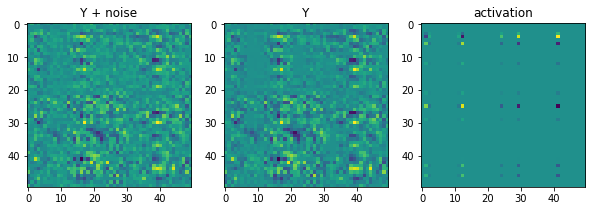

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Y[0])
plt.title('Y + noise')

plt.subplot(132)
plt.imshow(Ytrue[0])
plt.title('Y')

plt.subplot(133)
plt.imshow(Z[1, 0])
plt.title('activation')

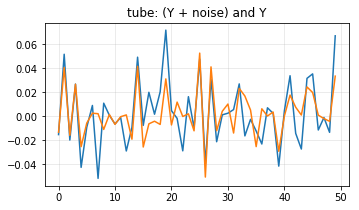

In [6]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(Y[0, 0])
plt.plot(Ytrue[0, 0])
plt.title('tube: (Y + noise) and Y')
plt.grid(alpha=.3)

In [7]:
# parameters of T-ConvFISTA

#=============== Full-loop
maxit_loop = 40
tol_loop = 0.0001
#=============== Z-step
maxit = 10000
Rpred = 2

rt = 300
lbd1 = .001
lbd2 = lbd1
lbd3 = lbd1

beta1 = .01
beta2 = beta1
beta3 = beta1

tol = 1e-11

#=============== D-step
maxit_d = 300

In [8]:
# Initial dictionary and precomputation of the DFT
np.random.seed(123)
D = np.random.uniform(-10000, 10000, size=(K, W1, W2, W3))/10
for k in range(K):
    D[k] /= max(np.linalg.norm(D[k]), 1)

Dchap = np.zeros((K, N1, N2, N3), dtype=np.complex)
Dchap1 = np.zeros((K, N1, N2*N3), dtype=np.complex)
Dchap2 = np.zeros((K, N2, N1*N3), dtype=np.complex)
Dchap3 = np.zeros((K, N3, N1*N2), dtype=np.complex)

dchap1 = np.zeros((K, N), dtype=np.complex)
dchap2 = np.zeros((K, N), dtype=np.complex)
dchap3 = np.zeros((K, N), dtype=np.complex)

dchapconj1 = np.zeros((K, N), dtype=np.complex)
dchapconj2 = np.zeros((K, N), dtype=np.complex)
dchapconj3 = np.zeros((K, N), dtype=np.complex)

for k in range(K):
    DD = np.zeros((N1, N2, N3)) # padding
    DD[:W1, :W2, :W3] = D[k]
    DDchap = fftn(DD)

    Dchap[k] = DDchap
    Dchap1[k] = unfold(DDchap, 0)
    Dchap2[k] = unfold(DDchap, 1)
    Dchap3[k] = unfold(DDchap, 2)

    dchap1[k] = ravel(unfold(Dchap[k], 0))
    dchap2[k] = ravel(unfold(Dchap[k], 1))
    dchap3[k] = ravel(unfold(Dchap[k], 2))

    dchapconj1[k] = ravel(unfold(Dchap[k].conj(), 0))
    dchapconj2[k] = ravel(unfold(Dchap[k].conj(), 1))
    dchapconj3[k] = ravel(unfold(Dchap[k].conj(), 2))
    
# Initialization of Sporco for the dictionary learning part
Dstart = np.zeros((N1, N2, N3, 1, 1, K))
Dstart_0 = np.zeros((W1, W2, W3, K))
for k in range(K):
    Dstart[:W1, :W2, :W3, 0, 0, k] = np.array(D[k])
    Dstart_0[:, :, :, k] = np.array(D[k])

# Setup of sporco
from sporco.admm import ccmod
opt_ccmod = ccmod.ConvCnstrMOD_IterSM.Options({'Verbose': False, 'MaxMainIter': maxit_d, 'AbsStopTol':1e-12, 'ZeroMean': False,
                                               'Y0': Dstart, 'U0': np.zeros((N1, N2, N3, 1, 1, K)),
                                               'AutoRho':{'Enabled':True}})

In [9]:
# Initial activation
np.random.seed(12345)
Z1init = np.random.normal(0, 10, size=(K, N1, Rpred))
Z2init = np.random.normal(0, 10, size=(K, N2, Rpred))
Z3init = np.random.normal(0, 10, size=(K, N3, Rpred))

Z1pred_fista = Z1init; z1pred = ravel(Z1pred_fista)
Z1chappred = fftn(Z1pred_fista, axes=[1])

Z2pred_fista = Z2init; z2pred = ravel(Z2pred_fista)
Z2chappred = fftn(Z2pred_fista, axes=[1])

Z3pred_fista = Z3init; z3pred = ravel(Z3pred_fista)
Z3chappred = fftn(Z3pred_fista, axes=[1])

Zfullpred = np.zeros((K, N1, N2, N3))
for k in range(K):
    Zfullpred[k] = kruskal_to_tensor((Z1init[k], Z2init[k], Z3init[k]))

M = []
for k in range(K):
    M.append(identity(Rpred))

Ypred = fftconv(D[0], Zfullpred[0], axes=(0, 1, 2))
for k in range(1, K):
    Ypred += fftconv(D[k], Zfullpred[k], axes=(0, 1, 2))

In [10]:
# Full TConvFISTA (Z-step and D-step)

pobj = []
this_pobj = (N * 0.5) * (linalg.norm(Y - Ypred) ** 2) + lbd1 * np.sum(abs(Z1pred_fista)) + lbd2 * np.sum(abs(Z2pred_fista)) + lbd3 * np.sum(abs(Z3pred_fista)) + beta1 * linalg.norm(Z1pred_fista)**2 + beta2 * linalg.norm(Z2pred_fista)**2 + beta3 * linalg.norm(Z3pred_fista)**2
pobj.append((0, this_pobj))
time0 = time.time()
for count_loop in range(maxit_loop):
    
    # ==============================================
    # ============================================== K-CSC
    # ==============================================

     # ============================================================ mode 1
    # Vectorization with Kruskal formulation
    Achap, L = f_Achap(M, Z3chappred, Z2chappred, dchap1, N1, K)
    AchapHAchap = Achap.conj().T.dot(Achap)
    Achapy = Achap.conj().T.dot(ychap1)
    if rt > 0:
        lbd1 = np.max(np.abs(Achapy)) / rt # automatique lbd
    # ============================================================
    L = eigsh(AchapHAchap + 2*beta1*identity(K*Rpred*N1), k=1, return_eigenvectors=False) # Liptschitz constant
    Z1pred_fista, _, _ = T_ConvFISTA_precompute(AchapHAchap, Achapy, Z1pred_fista, L, lbd1, beta1, maxit, tol=tol)
    Z1chappred = fftn(Z1pred_fista, axes=[1])

    # ============================================================ mode 2
    # Vectorization with Kruskal formulation
    Achap, L = f_Achap(M, Z3chappred, Z1chappred, dchap2, N2, K)
    AchapHAchap = Achap.conj().T.dot(Achap)
    Achapy = Achap.conj().T.dot(ychap2)
    if rt > 0:
        lbd2 = np.max(np.abs(Achapy)) / rt
    # ============================================================
    L = eigsh(AchapHAchap + 2*beta2*identity(K*Rpred*N2), k=1, return_eigenvectors=False) # Liptschitz constant
    Z2pred_fista, times_fista, pobj_fista = T_ConvFISTA_precompute(AchapHAchap, Achapy, Z2pred_fista, L, lbd2, beta2, maxit, tol=tol)
    Z2chappred = fftn(Z2pred_fista, axes=[1])
    
    # ============================================================ mode 3
    # Vectorization with Kruskal formulation
    Achap, L = f_Achap(M, Z2chappred, Z1chappred, dchap3, N3, K)
    AchapHAchap = Achap.conj().T.dot(Achap)
    Achapy = Achap.conj().T.dot(ychap3)
    if rt > 0:
        lbd3 = np.max(np.abs(Achapy)) / rt
    # ============================================================
    L = eigsh(AchapHAchap + 2*beta3*identity(K*Rpred*N3), k=1, return_eigenvectors=False) # Liptschitz constant
    Z3pred_fista, _, _ = T_ConvFISTA_precompute(AchapHAchap, Achapy, Z3pred_fista, L, lbd3, beta3, maxit, tol=tol)
    Z3chappred = fftn(Z3pred_fista, axes=[1])

    # ============================================================ full mode
    Zfullpred = np.zeros((K, N1, N2, N3))
    for k in range(K):
        ZM = np.array(Z1pred_fista[k].dot(M[k].todense())).reshape((N1, Rpred))
        Zfullpred[k] = kruskal_to_tensor((ZM, Z2pred_fista[k], Z3pred_fista[k]))

    # ==============================================
    # ============================================== K-CDL
    # ==============================================
    
    U = np.zeros((N1, N2, N3, 1, 1, K))
    for k in range(K):
        U[:, :, :, 0, 0, k] = np.array(Zfullpred[k])
        
    b = ccmod.ConvCnstrMOD_IterSM(U, Ydico, (W1, W2, W3, 1, 1, K), opt_ccmod, dimK=1, dimN=3)
    a = b.solve()

    # Update dico
    Dsporco = b.getdict()
    for k in range(K):
        D[k] = np.array(Dsporco[:, :, :, 0, 0, k])

    # Update initilization
    Dstart = np.zeros((N1, N2, N3, 1, 1, K))
    for k in range(K):
        Dstart[:W1, :W2, :W3, 0, 0, k] = np.array(D[k])
    opt_ccmod.update({'Y0': Dstart, 'U0': b.var_u()*0})

    # Precomputation
    Dchap = np.zeros((K, N1, N2, N3), dtype=np.complex)
    Dchap1 = np.zeros((K, N1, N2*N3), dtype=np.complex)
    Dchap2 = np.zeros((K, N2, N1*N3), dtype=np.complex)
    Dchap3 = np.zeros((K, N3, N1*N2), dtype=np.complex)

    dchap1 = np.zeros((K, N1*N2*N3), dtype=np.complex)
    dchap2 = np.zeros((K, N1*N2*N3), dtype=np.complex)
    dchap3 = np.zeros((K, N1*N2*N3), dtype=np.complex)

    dchapconj1 = np.zeros((K, N1*N2*N3), dtype=np.complex)
    dchapconj2 = np.zeros((K, N1*N2*N3), dtype=np.complex)
    dchapconj3 = np.zeros((K, N1*N2*N3), dtype=np.complex)

    for k in range(K):
        DD = np.zeros((N1, N2, N3)) # padding
        DD[:W1, :W2, :W3] = D[k]
        DDchap = fftn(DD)

        Dchap[k] = DDchap
        Dchap1[k] = unfold(DDchap, 0)
        Dchap2[k] = unfold(DDchap, 1)
        Dchap3[k] = unfold(DDchap, 2)

        dchap1[k] = ravel(unfold(Dchap[k], 0))
        dchap2[k] = ravel(unfold(Dchap[k], 1))
        dchap3[k] = ravel(unfold(Dchap[k], 2))

        dchapconj1[k] = ravel(unfold(Dchap[k].conj(), 0))
        dchapconj2[k] = ravel(unfold(Dchap[k].conj(), 1))
        dchapconj3[k] = ravel(unfold(Dchap[k].conj(), 2))
    # ==============================================
    # ==============================================
    # ==============================================

    Ypred = fftconv(D[0], Zfullpred[0], axes=(0, 1, 2))
    for k in range(1, K):
        Ypred += fftconv(D[k], Zfullpred[k], axes=(0, 1, 2))

    print('rmse:', rmse(Ytrue, Ypred), rmse(Z, Zfullpred))
    print('sparse', np.sum(abs(Zfullpred)>0), 100*np.sum(abs(Zfullpred)>0)/np.prod(Zfullpred.shape))

    this_pobj = (N * 0.5) * (linalg.norm(Y - Ypred) ** 2) + lbd1 * np.sum(abs(Z1pred_fista)) + lbd2 * np.sum(abs(Z2pred_fista)) + lbd3 * np.sum(abs(Z3pred_fista)) + beta1 * linalg.norm(Z1pred_fista)**2 + beta2 * linalg.norm(Z2pred_fista)**2 + beta3 * linalg.norm(Z3pred_fista)**2
    pobj.append((time.time() - time0, this_pobj))
    
    relTol = abs(pobj[-2][1]-this_pobj)/this_pobj
    print('relTol:', relTol)
    if relTol < tol_loop: # Stopping criterion
        break

print('rmse:', rmse(Ytrue, Ypred), rmse(Y, Ypred), rmse(Z, Zfullpred))
print('sparse:', np.sum(abs(Zfullpred)>0), 100*np.sum(abs(Zfullpred)>0)/np.prod(Zfullpred.shape))
print('Time:', time.time() - time0)

last iteration: 104.0
last iteration: 114.0
last iteration: 182.0
rmse: 0.04279550806802047 0.026861088411603774
sparse 356965 95.19066666666667
relTol: 2591384605.098731
last iteration: 109.0
last iteration: 1452.0
last iteration: 387.0
rmse: 0.036933533857421486 0.028464862720368533
sparse 201114 53.6304
relTol: 0.29113341418368205
last iteration: 104.0
last iteration: 415.0
last iteration: 417.0
rmse: 0.03448592263885061 0.02957783109573328
sparse 182349 48.6264
relTol: 0.12121778721213636
last iteration: 86.0
last iteration: 422.0
last iteration: 382.0
rmse: 0.03346644693462628 0.030204091026781205
sparse 167160 44.576
relTol: 0.05161368030530451
last iteration: 80.0
last iteration: 544.0
last iteration: 336.0
rmse: 0.03290447051608061 0.030583930863763552
sparse 135702 36.1872
relTol: 0.028517929036292956
last iteration: 82.0
last iteration: 398.0
last iteration: 380.0
rmse: 0.032270771633858095 0.030882625081656484
sparse 116043 30.9448
relTol: 0.03193698353270655
last iteration:

In [11]:
times, pobj = map(np.array, zip(*pobj))

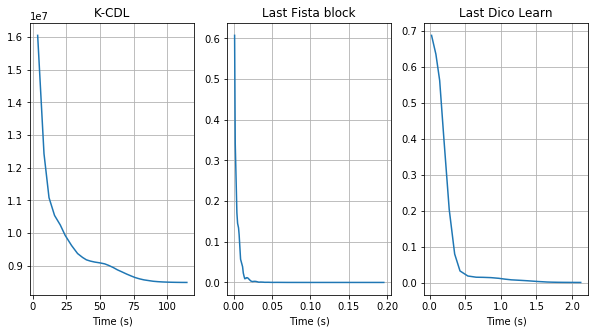

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(times[1:], pobj[1:])
plt.xlabel('Time (s)')
plt.title('K-CDL')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(times_fista, pobj_fista)
plt.xlabel('Time (s)')
plt.title('Last Fista block')
plt.grid()

its = b.getitstat()
plt.subplot(1, 3, 3)
plt.plot(its.Time, its.PrimalRsdl)
plt.xlabel('Time (s)')
plt.title('Last Dico Learn')
plt.grid()

Text(0.5, 1.0, 'Ypred')

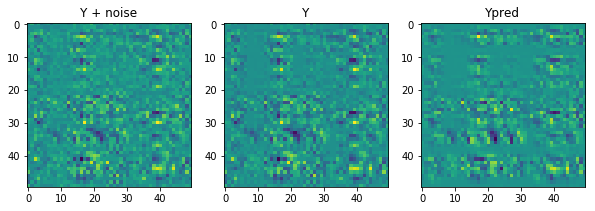

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Y[0])
plt.title('Y + noise')

plt.subplot(132)
plt.imshow(Ytrue[0])
plt.title('Y')

plt.subplot(133)
plt.imshow(Ypred[0])
plt.title('Ypred')